Delta_TL seq_len = 2

Using device: cuda


/tmp/ipykernel_3946708/452587366.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))



--- Evaluation on New File ---
RMSE: 1.3127
MAE: 0.9953
R²: 0.9700


/tmp/ipykernel_3946708/452587366.py:98: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


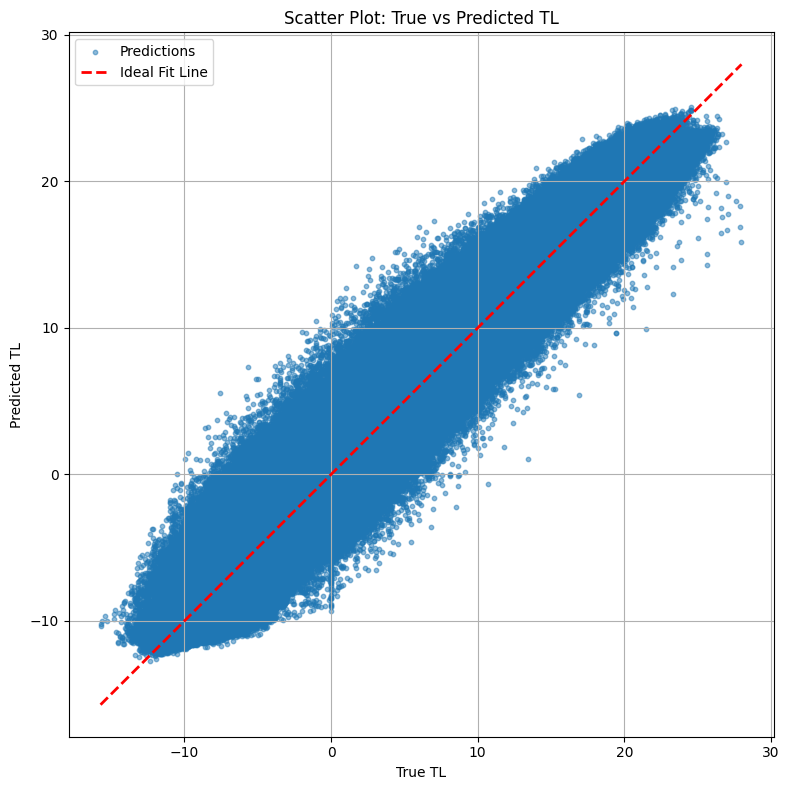

In [21]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
new_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/Model/rnn_tl_seq2.pth'
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/scalers/rnn_tl_seq2.save'
seq_len = 2
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL ===
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, h_n = self.rnn(x)
        return self.fc(h_n[-1])

# === LOAD SCALERS ===
scalers = joblib.load(scaler_save_path)

# === PREPROCESS NEW FILE ===
df = pd.read_csv(new_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

features = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo','TL']
df = df[features].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='TL').to_numpy()
    targets = df['TL'].to_numpy()
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)])
    y = targets[seq_len:]
    return X, y

X, y_true = make_sequences(df, seq_len)

# === APPLY SCALERS ===
for i in range(X.shape[2]):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

# === TO TENSOR ===
X_tensor = torch.from_numpy(X).float()
y_true_tensor = torch.from_numpy(y_true).float().unsqueeze(1)

loader = DataLoader(TensorDataset(X_tensor, y_true_tensor), batch_size=batch_size, shuffle=False)

# === LOAD MODEL ===
input_size = X.shape[2]
model = RNNModel(input_size=input_size).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# === PREDICT ===
preds = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
y_pred = np.concatenate(preds).flatten()

# === METRICS ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Evaluation on New File ---")
print(f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel("True TL")
plt.ylabel("Predicted TL")
plt.title("Scatter Plot: True vs Predicted TL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Delta_TL Seq_length=3 

Using device: cuda


/tmp/ipykernel_3946708/530762370.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))



--- Evaluation on New File ---
RMSE: 1.3127
MAE: 0.9953
R²: 0.9700


/tmp/ipykernel_3946708/530762370.py:98: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


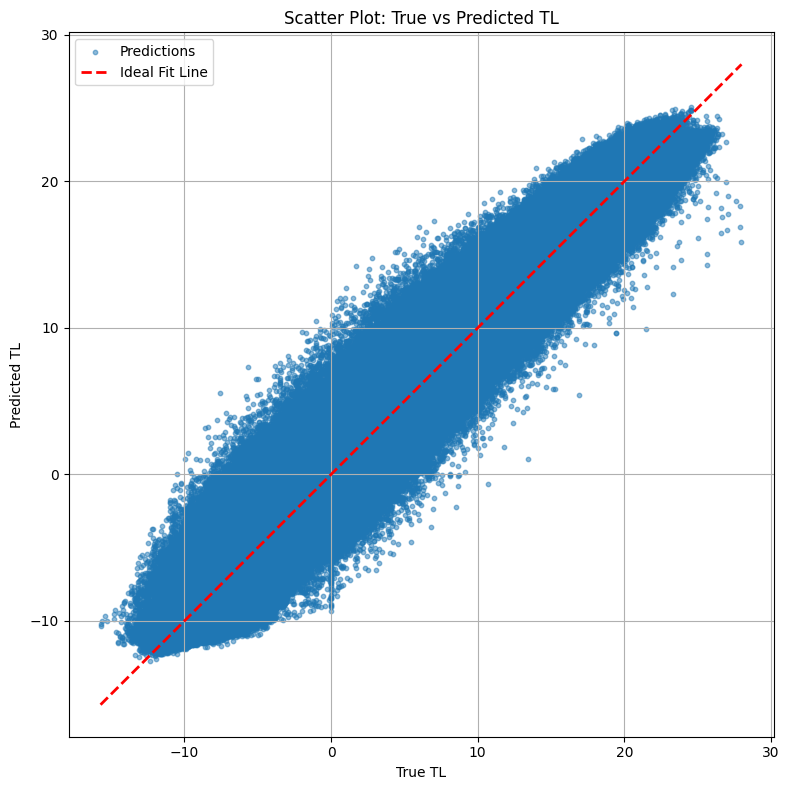

In [22]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
new_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/Model/rnn_tl_seq3_albx.pth'
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/scalers/rnn_tl_seq3_albx.save'
seq_len = 2
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL ===
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, h_n = self.rnn(x)
        return self.fc(h_n[-1])

# === LOAD SCALERS ===
scalers = joblib.load(scaler_save_path)

# === PREPROCESS NEW FILE ===
df = pd.read_csv(new_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

features = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo','TL']
df = df[features].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='TL').to_numpy()
    targets = df['TL'].to_numpy()
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)])
    y = targets[seq_len:]
    return X, y

X, y_true = make_sequences(df, seq_len)

# === APPLY SCALERS ===
for i in range(X.shape[2]):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

# === TO TENSOR ===
X_tensor = torch.from_numpy(X).float()
y_true_tensor = torch.from_numpy(y_true).float().unsqueeze(1)

loader = DataLoader(TensorDataset(X_tensor, y_true_tensor), batch_size=batch_size, shuffle=False)

# === LOAD MODEL ===
input_size = X.shape[2]
model = RNNModel(input_size=input_size).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# === PREDICT ===
preds = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
y_pred = np.concatenate(preds).flatten()

# === METRICS ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Evaluation on New File ---")
print(f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel("True TL")
plt.ylabel("Predicted TL")
plt.title("Scatter Plot: True vs Predicted TL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda


/tmp/ipykernel_16113/650297511.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))



--- Evaluation on New File ---
RMSE: 0.0320
MAE: 0.0212
R²: 0.9440


/tmp/ipykernel_16113/650297511.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


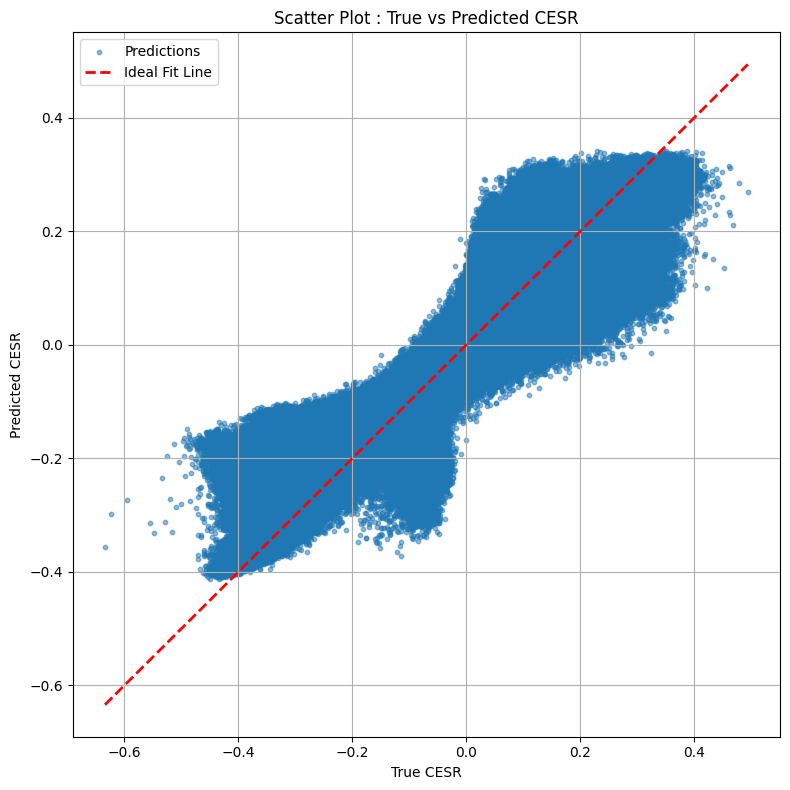

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
new_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/Model/rnn_cesr_seq2_albx.pth'
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/scalers/rnn_cesr_seq2_albx.save'
seq_len = 2
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL ===
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, h_n = self.rnn(x)
        return self.fc(h_n[-1])

# === LOAD SCALERS ===
scalers = joblib.load(scaler_save_path)

# === PREPROCESS NEW FILE ===
df = pd.read_csv(new_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

features = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo','CESR']
df = df[features].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='CESR').to_numpy()
    targets = df['CESR'].to_numpy()
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)])
    y = targets[seq_len:]
    return X, y

X, y_true = make_sequences(df, seq_len)

for i in range(X.shape[2]):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

X_tensor = torch.from_numpy(X).float()
y_true_tensor = torch.from_numpy(y_true).float().unsqueeze(1)

loader = DataLoader(TensorDataset(X_tensor, y_true_tensor), batch_size=batch_size, shuffle=False)

# === LOAD MODEL ===
input_size = X.shape[2]
model = RNNModel(input_size=input_size).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# === PREDICT ===
preds = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
y_pred = np.concatenate(preds).flatten()

# === METRICS ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Evaluation on New File ---")
print(f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel("True CESR")
plt.ylabel("Predicted CESR")
plt.title("Scatter Plot : True vs Predicted CESR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CESR seq 3

Using device: cuda


/tmp/ipykernel_16113/3024829021.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))



--- Evaluation on New File ---
RMSE: 0.0305
MAE: 0.0202
R²: 0.9493


/tmp/ipykernel_16113/3024829021.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


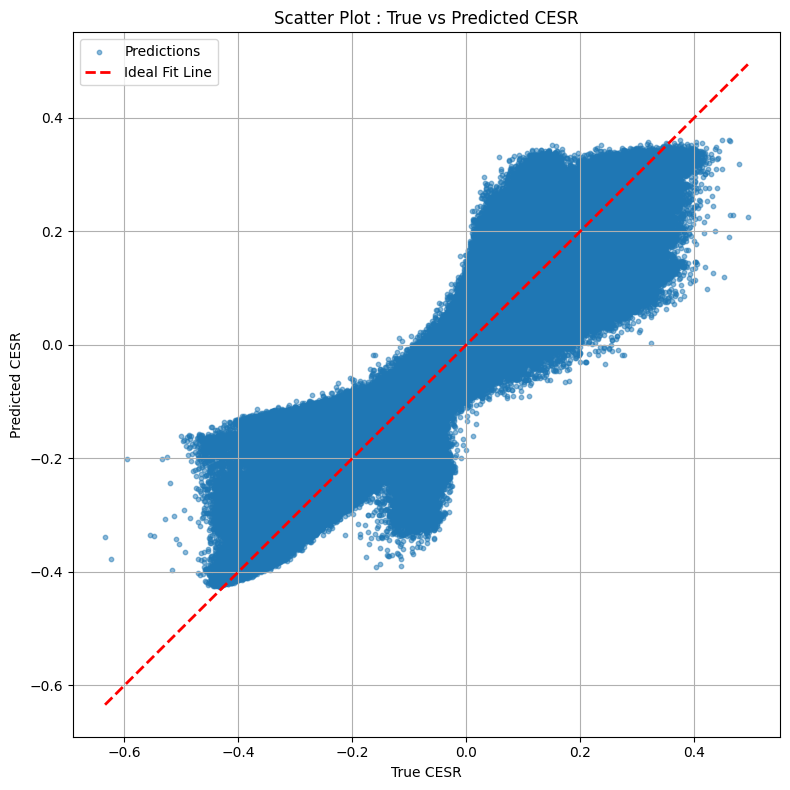

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
new_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS
model_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/Model/rnn_cesr_seq3_albx.pth'
scaler_save_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/RNN/scalers/rnn_cesr_seq3_albx.save'
seq_len = 3
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === MODEL ===
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, h_n = self.rnn(x)
        return self.fc(h_n[-1])

# === LOAD SCALERS ===
scalers = joblib.load(scaler_save_path)

# === PREPROCESS NEW FILE ===
df = pd.read_csv(new_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

features = ['AirTemp','Wind','Tdp','Solar','sin_doy','cos_doy','sin_hour','cos_hour','Depth','Albedo','CESR']
df = df[features].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='CESR').to_numpy()
    targets = df['CESR'].to_numpy()
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)])
    y = targets[seq_len:]
    return X, y

X, y_true = make_sequences(df, seq_len)

for i in range(X.shape[2]):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

X_tensor = torch.from_numpy(X).float()
y_true_tensor = torch.from_numpy(y_true).float().unsqueeze(1)

loader = DataLoader(TensorDataset(X_tensor, y_true_tensor), batch_size=batch_size, shuffle=False)

# === LOAD MODEL ===
input_size = X.shape[2]
model = RNNModel(input_size=input_size).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

# === PREDICT ===
preds = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
y_pred = np.concatenate(preds).flatten()

# === METRICS ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Evaluation on New File ---")
print(f"RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# === SCATTER PLOT ===
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel("True CESR")
plt.ylabel("Predicted CESR")
plt.title("Scatter Plot : True vs Predicted CESR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
